# Multiple Linear Regression

blablabla

In [1]:
# import section ------------------------------------------------------------------------------------------------------------- #

# relational database and mathematics related libraries ---------------------------------------------------------------------- #
import numpy as np
import pandas as pd
import statsmodels.api as sm

# specific functions and models ---------------------------------------------------------------------------------------------- #
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats import diagnostic as diag

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# libraries for visualization ------------------------------------------------------------------------------------------------ #
import seaborn as sns
import matplotlib.pyplot as plt

# load the data and save it into a dataframe --------------------------------------------------------------------------------- #
easy_df = pd.read_csv("https://raw.githubusercontent.com/Codecademy/datasets/master/streeteasy/streeteasy.csv")

print(easy_df.head())

   rental_id  building_id   rent  bedrooms  bathrooms  size_sqft  \
0       1545     44518357   2550       0.0          1        480   
1       2472     94441623  11500       2.0          2       2000   
2      10234     87632265   3000       3.0          1       1000   
3       2919     76909719   4500       1.0          1        916   
4       2790     92953520   4795       1.0          1        975   

   min_to_subway  floor  building_age_yrs  no_fee  has_roofdeck  \
0              9    2.0                17       1             1   
1              4    1.0                96       0             0   
2              4    1.0               106       0             0   
3              2   51.0                29       0             1   
4              3    8.0                31       0             0   

   has_washer_dryer  has_doorman  has_elevator  has_dishwasher  has_patio  \
0                 0            0             1               1          0   
1                 0            0  

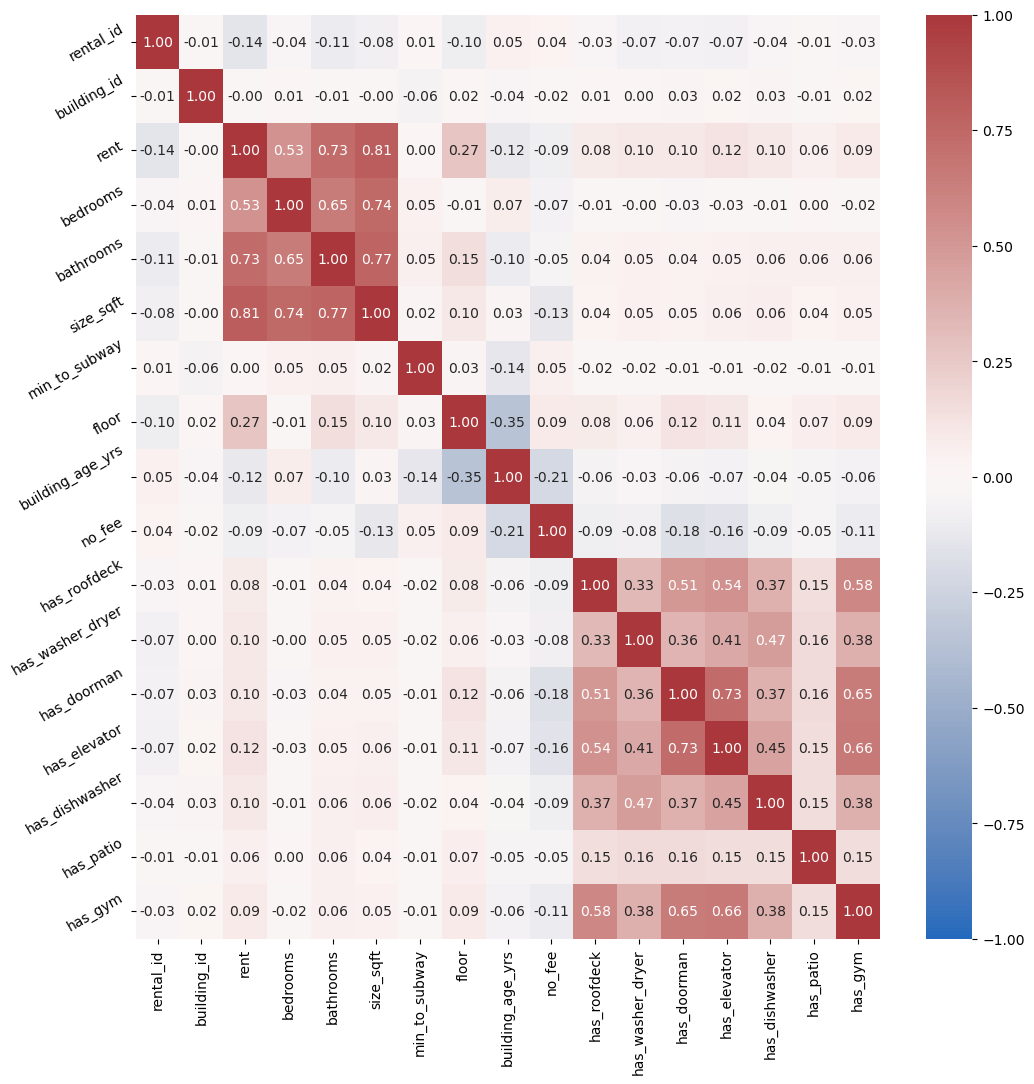

In [2]:
# correlation matrix --------------------------------------------------------------------------------------------------------- #
corr = easy_df.corr()

plt.figure(figsize=(12,12))
sns.heatmap(corr, vmin=-1, vmax=1, xticklabels=corr.columns, yticklabels=corr.columns, cmap="vlag", annot=True, fmt=".2f")
plt.yticks(rotation=30)
plt.show()

<Figure size 640x480 with 0 Axes>

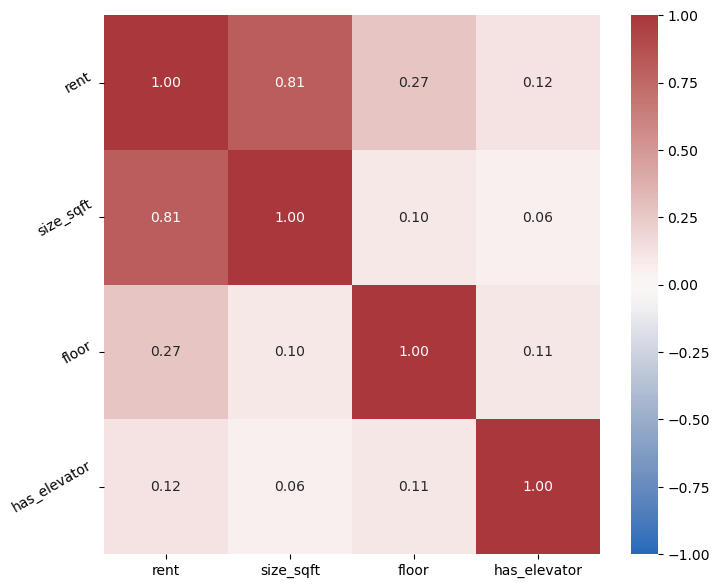

In [3]:
# removing explaining variables, which are highly correlated with other explaining variables --------------------------------- #
# or which do not add any or only very little explainatory value ------------------------------------------------------------- #
no_mc_easy_df = easy_df.drop(columns=["rental_id", "building_id", "bedrooms", "bathrooms", "min_to_subway", "building_age_yrs", "no_fee","has_roofdeck", "has_washer_dryer", "has_doorman", "has_dishwasher", "has_patio", "has_gym"])

# correlation matrix --------------------------------------------------------------------------------------------------------- #
no_mc_corr = no_mc_easy_df.corr()

plt.clf()
plt.figure(figsize=(8,7))
sns.heatmap(no_mc_corr, vmin=-1, vmax=1, xticklabels=no_mc_corr.columns, yticklabels=no_mc_corr.columns, cmap="vlag", annot=True, fmt=".2f")
plt.yticks(rotation=30)
plt.show()

In [4]:
# Variance Inflation Factor, before and after dropping independent variables ------------------------------------------------- #
  
# dataframes of explaining variables (x), having removed the explained variable (y) ------------------------------------------ #
X_1 = easy_df[["rental_id", "building_id", "bedrooms", "bathrooms", "size_sqft", "min_to_subway", "floor", "building_age_yrs", "no_fee","has_roofdeck", "has_washer_dryer", "has_doorman", "has_elevator", "has_dishwasher", "has_patio", "has_gym"]]

X_2 = no_mc_easy_df[["size_sqft", "floor", "has_elevator"]]
  
# VIF dataframe -------------------------------------------------------------------------------------------------------------- #
vif_data_1 = pd.DataFrame()
vif_data_1["feature"] = X_1.columns

vif_data_2 = pd.DataFrame()
vif_data_2["feature"] = X_2.columns
  
# calculating VIF for each feature ------------------------------------------------------------------------------------------- #
vif_data_1["VIF"] = [variance_inflation_factor(X_1.values, i) for i in range(len(X_1.columns))]

vif_data_2["VIF"] = [variance_inflation_factor(X_2.values, i) for i in range(len(X_2.columns))]

print("Before dropping explaining variables:")
print(vif_data_1)
print("")
print("After dropping explaining variables:")
print(vif_data_2)

Before dropping explaining variables:
             feature        VIF
0          rental_id   3.266029
1        building_id   3.565830
2           bedrooms   7.277568
3          bathrooms  15.634731
4          size_sqft  17.937643
5      min_to_subway   1.865221
6              floor   2.163173
7   building_age_yrs   2.566683
8             no_fee   1.770510
9       has_roofdeck   1.902901
10  has_washer_dryer   1.624653
11       has_doorman   3.162696
12      has_elevator   3.501202
13    has_dishwasher   1.739966
14         has_patio   1.102090
15           has_gym   2.599310

After dropping explaining variables:
        feature       VIF
0     size_sqft  1.917156
1         floor  1.804252
2  has_elevator  1.306807
